In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import lzma
import json
import urllib.request
import shutil
%matplotlib inline

In [83]:
url = 'https://www.dropbox.com/s/6psloxyc0ekqzh2/data.jsonl.xz?dl=1'

with urllib.request.urlopen(url) as response, open("data.jsonl.xz", 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

This demo is designed to get you up and running with a sample of CAP data available here https://capapi.org/bulk-access/. Feel free to reuse, modify, or distribute it however you'd like. **Most of this code is written to be adaptable to different chunks of CAP data!** You can substitute in another .xz file corresponding to a different jurisdiction or mess around with any number of other parameters.

First, let's get the data into a format we can work with by decompressing the Illinois bulk file and pulling 1-year batches of cases at 10 year intervals from 1900 to 2000. This should give us a good sampling over time.

In [98]:
#a list to hold the cases we're sampling
cases = []

#decompress the file line by line
with lzma.open("data.jsonl.xz") as infile:
    for line in infile:
        #decode the file into a convenient format
        record = json.loads(str(line, 'utf-8'))
        #if the decision date on the case matches one we're interested in, add to our list
        cases.append(record)

print("Number of Cases: {}".format(len(cases)))

Number of Cases: 58944


Let's take a look at the case format by accessing the first entry in our list of matching cases.

In [99]:
cases[0]

{'id': 236605,
 'name': 'The United States vs. Thomas Dickinson',
 'name_abbreviation': 'United States v. Dickinson',
 'decision_date': '1820-01',
 'docket_number': '',
 'first_page': '1',
 'last_page': '3',
 'citations': [{'type': 'official', 'cite': '1 Ark. Terr. Rep. 1'}],
 'volume': {'volume_number': '1'},
 'reporter': {'full_name': 'Reports of Cases Argued and Determined in the United States Superior Court for the Territory of Arkansas, from 1820 to 1836'},
 'court': {'id': 9132,
  'name': 'Superior Court of the Territory of Arkansas',
  'name_abbreviation': 'Ark. Super. Ct.',
  'jurisdiction_url': None,
  'slug': 'ark-super-ct'},
 'jurisdiction': {'id': 34,
  'slug': 'ark',
  'name': 'Ark.',
  'name_long': 'Arkansas',
  'whitelisted': True},
 'casebody': {'data': {'judges': [],
   'parties': ['The United States vs. Thomas Dickinson.'],
   'opinions': [{'type': 'majority',
     'author': None,
     'text': "This was an indictment for rape committed on the person of Sally Hall, to 

A lot of info here, but it's quite messy. Let's pull out a few case metadata attributes we're interested in, leaving the actual case text aside for now – the decision date (year only), case name, case citation, court, and opinion count. We'll put them into a Pandas Dataframe for easier manipulation. 

In [100]:
# use a list comprehension to pull out the metadata attributes specified above
case_metadata = [{'year': int(case['decision_date'][:4]),
                'name': case['name'],
                'citation': case['citations'][0]['cite'],
                'court': case['court']['name'],
                'opinion_count': len(case['casebody']['data']['opinions'])} 
                 for case in cases]

# lists of dictionaries like `case_metadata` convert easily into Dataframes
metadata_df = pd.DataFrame(case_metadata)
metadata_df.head()

,citation,court,name,opinion_count,year
0,1 Ark. Terr. Rep. 1,Superior Court of the Territory of Arkansas,The United States vs. Thomas Dickinson,1,1820
1,Hempst 1,Superior Court of the Territory of Arkansas,UNITED STATES v. DICKINSON,1,1820
2,1 Ark. Terr. Rep. 3,Superior Court of the Territory of Arkansas,William Russell vs. Amos Wheeler et al.,1,1821
3,1 Ark. Terr. Rep. 8,Superior Court of the Territory of Arkansas,Thompson and Mathews vs. Campbell,1,1821
4,1 Ark. Terr. Rep. 9,Superior Court of the Territory of Arkansas,Hewes Scull vs. Joseph Kuykendall,1,1821


Yay, we've got our first usable data! As minimal as this metadata is, we should still be able to get some useful insights out of it. First, let's check how many cases we have from each year in our sample.

In [101]:
metadata_df['year'].value_counts().sort_index()

1820      2
1821      7
1822     16
1823      3
1824     10
1825     11
1826     15
1827     10
1828     22
1829     11
1830      4
1831     18
1832     28
1833     24
1834     15
1835     20
1836     10
1837      8
1838     37
1839     42
1840     67
1841     60
1842    150
1843     86
1844     95
1845     76
1846    115
1847    136
1848    110
1849     88
       ... 
1988    542
1989    606
1990    594
1991    555
1992    588
1993    571
1994    658
1995    581
1996    701
1997    654
1998    634
1999    555
2000    601
2001    588
2002    554
2003    573
2004    602
2005    575
2006    557
2007    551
2008    533
2009    539
2010    415
2011    375
2012    320
2013    250
2014    437
2015    551
2016    570
2017      2
Name: year, Length: 197, dtype: int64

There's clearly a lot of variation in publication volume year to year, with pronounced upticks in 1980 and 2000. Let's break it down by court.

In [102]:
metadata_df['court'].value_counts().sort_index()

Arkansas Circuit Court                            57
Arkansas Court of Appeals                       7973
Arkansas District Court                           13
Arkansas Superior Court                            9
Arkansas Supreme Court                         50675
Court Abbreviations Arkansas Supreme Court         1
Superior Court of the Territory of Arkansas      216
Name: court, dtype: int64

All of the cases in our sample are from either the Arkansas Court of Appeals or the Arkansas Supreme Court, with a large majority belonging to the latter. Let's look at the number of opinions per case.

In [103]:
metadata_df['opinion_count'].value_counts().sort_index()

0       16
1    51243
2     6459
3     1018
4      168
5       34
6        2
7        3
8        1
Name: opinion_count, dtype: int64

The majority of our cases have a single opinion. Let's try to identify some trends in opinion volume over time.

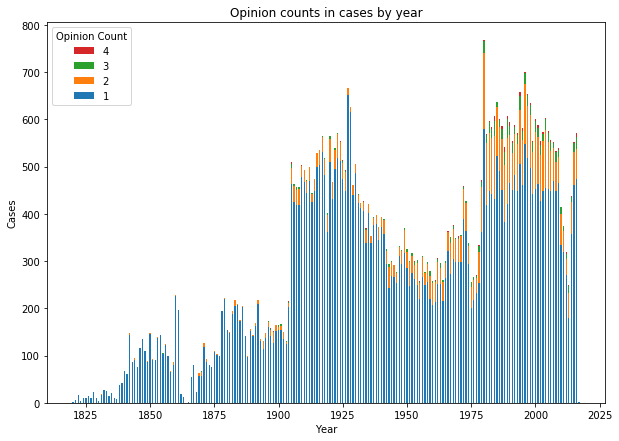

In [104]:
# get frequency of opinion counts for each year
n_opinions = [[year, 
               metadata_df[(metadata_df['year'] == year) & (metadata_df["opinion_count"] == 1)].shape[0],
               metadata_df[(metadata_df['year'] == year) & (metadata_df["opinion_count"] == 2)].shape[0],
               metadata_df[(metadata_df['year'] == year) & (metadata_df["opinion_count"] == 3)].shape[0],
               metadata_df[(metadata_df['year'] == year) & (metadata_df["opinion_count"] >= 4)].shape[0]]
              for year in metadata_df['year'].unique()]

# reformat for graph
n_opinions = list(zip(*n_opinions))
n_opinions = [list(item) for item in n_opinions]
plt.figure(figsize=(10,7))

ind = n_opinions[0]
handles = []
for i, count in enumerate(n_opinions[1:]):
    bot = n_opinions[1:i+1]
    bot = [sum(x) for x in zip(*n_opinions[1:i+1])]
    bot = [0]*len(ind) if not bot else bot
    h = plt.bar(ind, count, .5, bottom=bot, label=i+1)
    handles.append(h)
    
plt.legend(handles=handles[::-1], title="Opinion Count")
plt.xlabel("Year")
plt.ylabel("Cases")
plt.title("Opinion counts in cases by year")
plt.show()

Interesting – it seems that cases from 1980, 1990, and 2000 tend to have more opinions than those from earlier years in the sample.

Now let's get to the rich part of the dataset – the opinions themselves! These are a bit messier to wrangle than the metadata was. There are a couple ways that we might structure our dataframe, but to keep it simple we'll just do one opinion per row. If a case has multiple opinions, each will be a separate row (linked by the case id).

In [106]:
#Loop through cases and build rows with case metadata AND opinion metadata/text.
#We load in all of the keys initially, then modify the ones we want to.

opinion_data = []
for case in cases:
    for opinion in case["casebody"]["data"]["opinions"]:
        temp = {}
        keys = list(case.keys())
        keys.remove('casebody')
        for key in keys:         
            temp[key] = case[key]
        keys = list(opinion.keys())
        for key in keys:         
            temp[key] = opinion[key]
        opinion_data.append(temp)

opinions_df = pd.DataFrame(opinion_data)
opinions_df["citations"] = opinions_df["citations"].apply(lambda x:x[0]['cite'])
opinions_df["court"] = opinions_df["court"].apply(lambda x:x['name'])
opinions_df["decision_date"] = opinions_df["decision_date"].apply(lambda x:int(x[:4]))
opinions_df = opinions_df.drop(["docket_number", "first_page", 
                                "last_page", "name_abbreviation",
                                "reporter", "volume", "jurisdiction"], axis=1)
opinions_df = opinions_df[["id", "name", "decision_date", "court", "citations", "author", "type", "text"]]

opinions_df.head()

,id,name,decision_date,court,citations,author,type,text
0,236605,The United States vs. Thomas Dickinson,1820,Superior Court of the Territory of Arkansas,1 Ark. Terr. Rep. 1,None,majority,This was an indictment for rape committed on t...
1,6611556,UNITED STATES v. DICKINSON,1820,Superior Court of the Territory of Arkansas,Hempst 1,THE COURT,majority,"THE COURT\noverruled the motion, and said that..."
2,236518,William Russell vs. Amos Wheeler et al.,1821,Superior Court of the Territory of Arkansas,1 Ark. Terr. Rep. 3,"Johnson, J.,",majority,"Johnson, J.,\ndelivered the opinion of the Cou..."
3,236580,Thompson and Mathews vs. Campbell,1821,Superior Court of the Territory of Arkansas,1 Ark. Terr. Rep. 8,None,majority,Opinion op the Court.— It is clear that the co...
4,236682,Hewes Scull vs. Joseph Kuykendall,1821,Superior Court of the Territory of Arkansas,1 Ark. Terr. Rep. 9,None,majority,Opinion oe the Court. — The court below dismis...


After dropping some extraneous information, we're left with a number of useful attributes for each opinion:

- id (assigned by CAP database): A unique case identifier that we can use to link opinions belonging to the same case
- name: The case's name
- court: The court in which the case was heard and decided
- citations: The official citation to the case
- author: The author of the opinion
- type: The type of the opinion (ex. 'majority,''dissent,''concurrence')
- text: The full text of the opinion

Let's try to a more complicated question using this corpus. Comparing cases from 1900, 1910, 1920, and 1930 against cases from 1970, 1980, 1990, and 2000, what words can we say are distinctive to each time period? Are there words from opinions dating to the beginning of the 20th century that don't occur in opinions dating to the end of the 20th century?

We'll start by implementing a basic n-gram search function and graphing our results. 

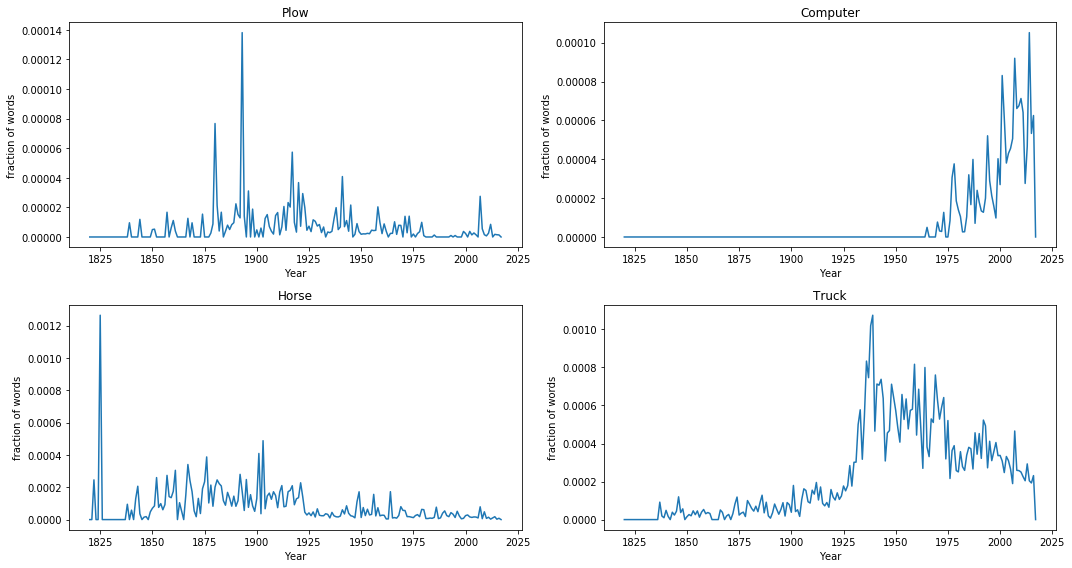

In [107]:
def search_ngram(ngram):
    pairs = []
    for year in opinions_df["decision_date"].unique():
        temp = opinions_df[opinions_df["decision_date"] == year]["text"].tolist()
        temp = " ".join(temp).lower()
        n = len(temp.split(" "))
        ngram_count = temp.count(ngram.lower())
        pairs.append((year, ngram_count/n))
    return pairs

def graph_ngram(pairs, ax, title):
    x,y = [list(x) for x in zip(*pairs)]
    ax.plot(x,y)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("fraction of words")
    return ax

fig, axes = plt.subplots(2, 2, figsize=(15,8))
graph_ngram(search_ngram("plow"), axes[0,0], "Plow")
graph_ngram(search_ngram("computer"), axes[0,1], "Computer")
graph_ngram(search_ngram("horse"), axes[1,0], "Horse")
graph_ngram(search_ngram("truck"), axes[1,1], "Truck")

plt.tight_layout()
plt.show()

Fewer horses and plows, more trucks and computers! Let's get a little bit more sophisticated (still keeping it simple) and find a list of words which occur fewer than 10 times in cases from 1900-1940 but frequently in cases from 1970-2000.

In [108]:
def tokenize_cases(cases):
    cases = " ".join(cases).lower()
    cases = cases.replace("\n", " ").replace(",", "").replace(";", "").replace("'", "").replace("’", "")
    cases = cases.replace("(", "").replace(")", "").replace(".", "").replace("?", "").replace("!", "").split(" ")
    return cases

early_cases = tokenize_cases(opinions_df[opinions_df["decision_date"] <= 1930]["text"].tolist())
late_cases = tokenize_cases(opinions_df[opinions_df["decision_date"] >= 1970]["text"].tolist())

In [109]:
early_cases_dict = {}

for word in early_cases:
    if word in early_cases_dict:
        early_cases_dict[word] += 1
    else:
        early_cases_dict[word] = 1

len(early_cases_dict)

219366

In [110]:
new_words_dict = {}

for word in late_cases:
    if word in early_cases_dict:
        if early_cases_dict[word] < 10:
            if word in new_words_dict:
                new_words_dict[word] += 1
            else:
                new_words_dict[word] = 1
    else:
        if word in new_words_dict:
            new_words_dict[word] += 1
        else:
            new_words_dict[word] = 1

In [111]:
def isInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

sorted_new_words = sorted(new_words_dict.items(), key=lambda x:-x[1])
sorted_new_words = [item for item in sorted_new_words if not isInt(item[0])]
sorted_new_words = sorted_new_words[:100]

print("Most common words from 1970-2000 that occured <10 times from 1900-1930\n")
print ("{0:14}|{1:5}".format("Word", "Occurances"))
print ("-------------------------")
for word in sorted_new_words:
    print ("{0:14}|{1:5}".format(word[0], word[1]))

Most common words from 1970-2000 that occured <10 times from 1900-1930

Word          |Occurances
-------------------------
sw2d          |118993
sw3d          |49736
repl          |18784
coverage      | 7282
dhs           | 6966
marijuana     | 6206
arkcode       | 5190
problems      | 4928
compensable   | 4769
factual       | 4542
methamphetamine| 4304
wl            | 4258
additionally  | 4138
procedures    | 4090
arkapp        | 3971
sct           | 3931
dept          | 3925
f2d           | 3509
program       | 3494
servs         | 3423
evaluation    | 3334
initially     | 2951
pretrial      | 2919
postconviction| 2904
trailer       | 2847
wal-mart      | 2823
procedural    | 2721
informant     | 2663
allegedly     | 2654
majoritys     | 2556
first-degree  | 2535
multiple      | 2499
firearm       | 2459
custodial     | 2403
alj           | 2400
p2d           | 2363
evid          | 2338
led2d         | 2306
totality      | 2291
contraband    | 2235
larry         | 2226
commn        

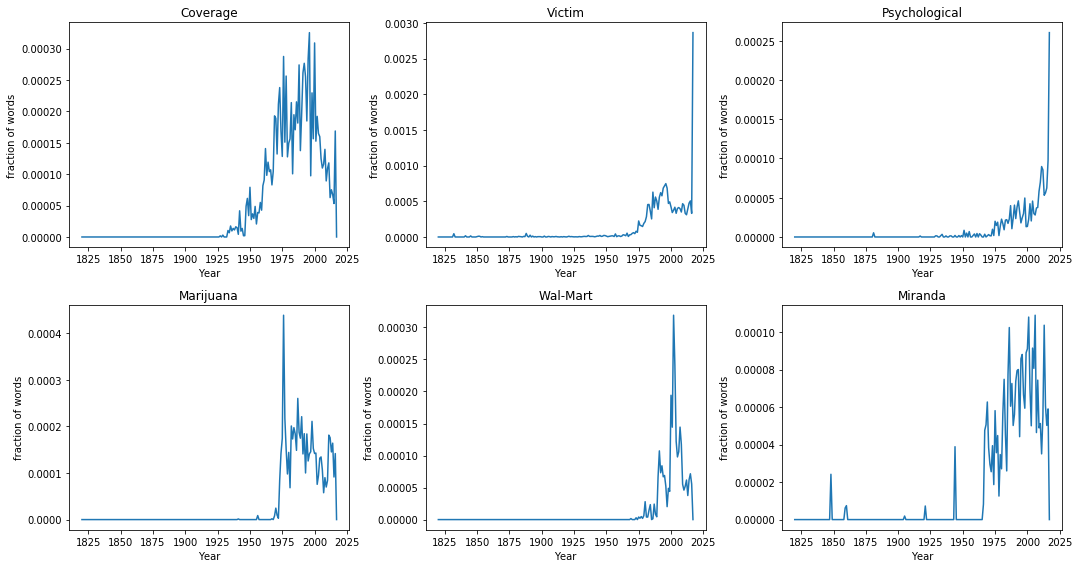

In [113]:
fig, axes = plt.subplots(2, 3, figsize=(15,8))
graph_ngram(search_ngram("coverage"), axes[0,0], "Coverage")
graph_ngram(search_ngram("victim"), axes[0,1], "Victim")
graph_ngram(search_ngram("marijuana"), axes[1,0], "Marijuana")
graph_ngram(search_ngram("wal-mart"), axes[1,1], "Wal-Mart")
graph_ngram(search_ngram("miranda"), axes[1,2], "Miranda")
graph_ngram(search_ngram("psychological"), axes[0,2], "Psychological")



plt.tight_layout()
plt.show()

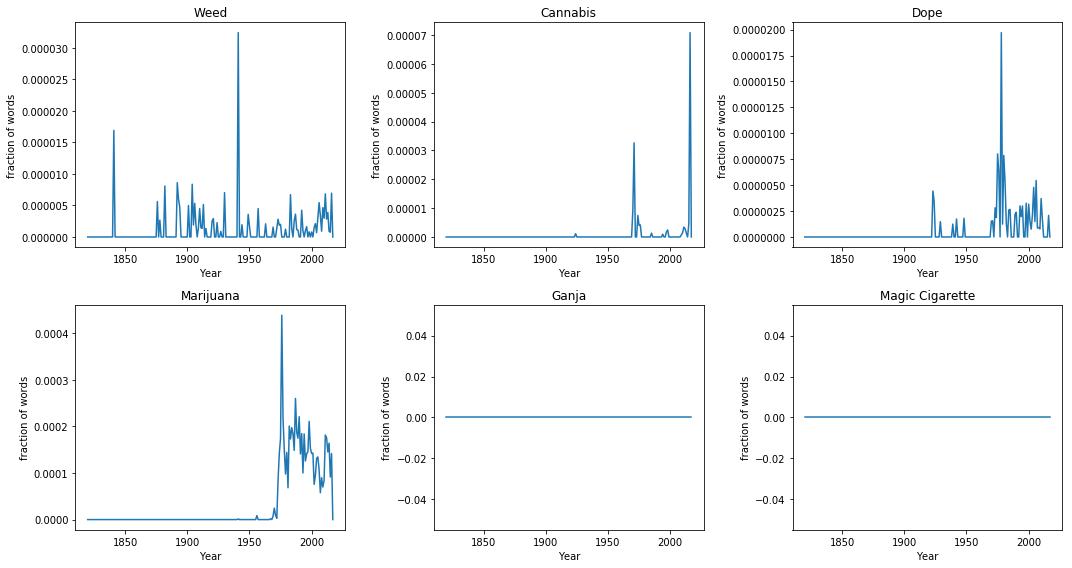

In [114]:
fig, axes = plt.subplots(2, 3, figsize=(15,8))
graph_ngram(search_ngram(" weed "), axes[0,0], "Weed")
graph_ngram(search_ngram("cannabis"), axes[0,1], "Cannabis")
graph_ngram(search_ngram("marijuana"), axes[1,0], "Marijuana")
graph_ngram(search_ngram("ganja"), axes[1,1], "Ganja")
graph_ngram(search_ngram("magic cigarette"), axes[1,2], "Magic Cigarette")
graph_ngram(search_ngram(" dope "), axes[0,2], "Dope")

plt.tight_layout()
plt.show()

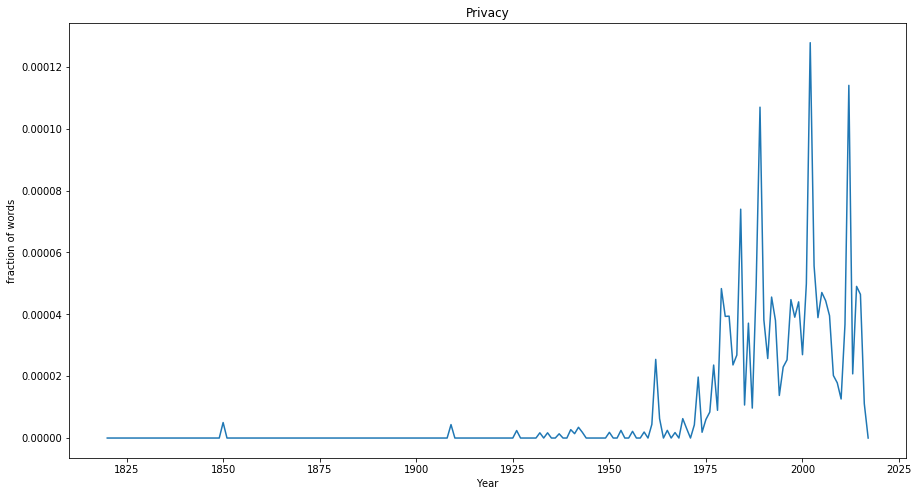

In [117]:
fig, axes = plt.subplots(1, figsize=(15,8))
graph_ngram(search_ngram("privacy"), axes, "Privacy")